# Classifying Handwritten Digits

In this notebook we will apply the LogitBoost algorithm to a toy dataset to identify handwritten digits.

## Imports

In [1]:
from __future__ import print_function, division
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import seaborn as sns
sns.set(style='darkgrid', palette='colorblind', color_codes=True)

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, classification_report

from logitboost import LogitBoost

## Loading the Data

We use the [UCI ML handwritten digits dataset](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits), imported from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html).
This dataset contains 1797 8-by-8 images of handwritten digits.
After shuffling the data, we split them into training and testing sets.

In [2]:
digits = load_digits()
X = digits.data
y = digits.target
images = digits.images
n_classes = 10

# Scale the digits for numerical stability
# The pixel intensities are integers 0-15
X /= 15

# Shuffle the data and split them into training and testing sets
test_size = 1 / 3
X_train, X_test, y_train, y_test, images_train, images_test \
    = train_test_split(X, y, images, test_size=test_size, shuffle=True,
                       stratify=y, random_state=0)

print('Training shape: ', X_train.shape)
print('Test shape:     ', X_test.shape)

Training shape:  (1198, 64)
Test shape:      (599, 64)


## Visualizing the Training Set

We begin by displaying a handful of images in the training set.

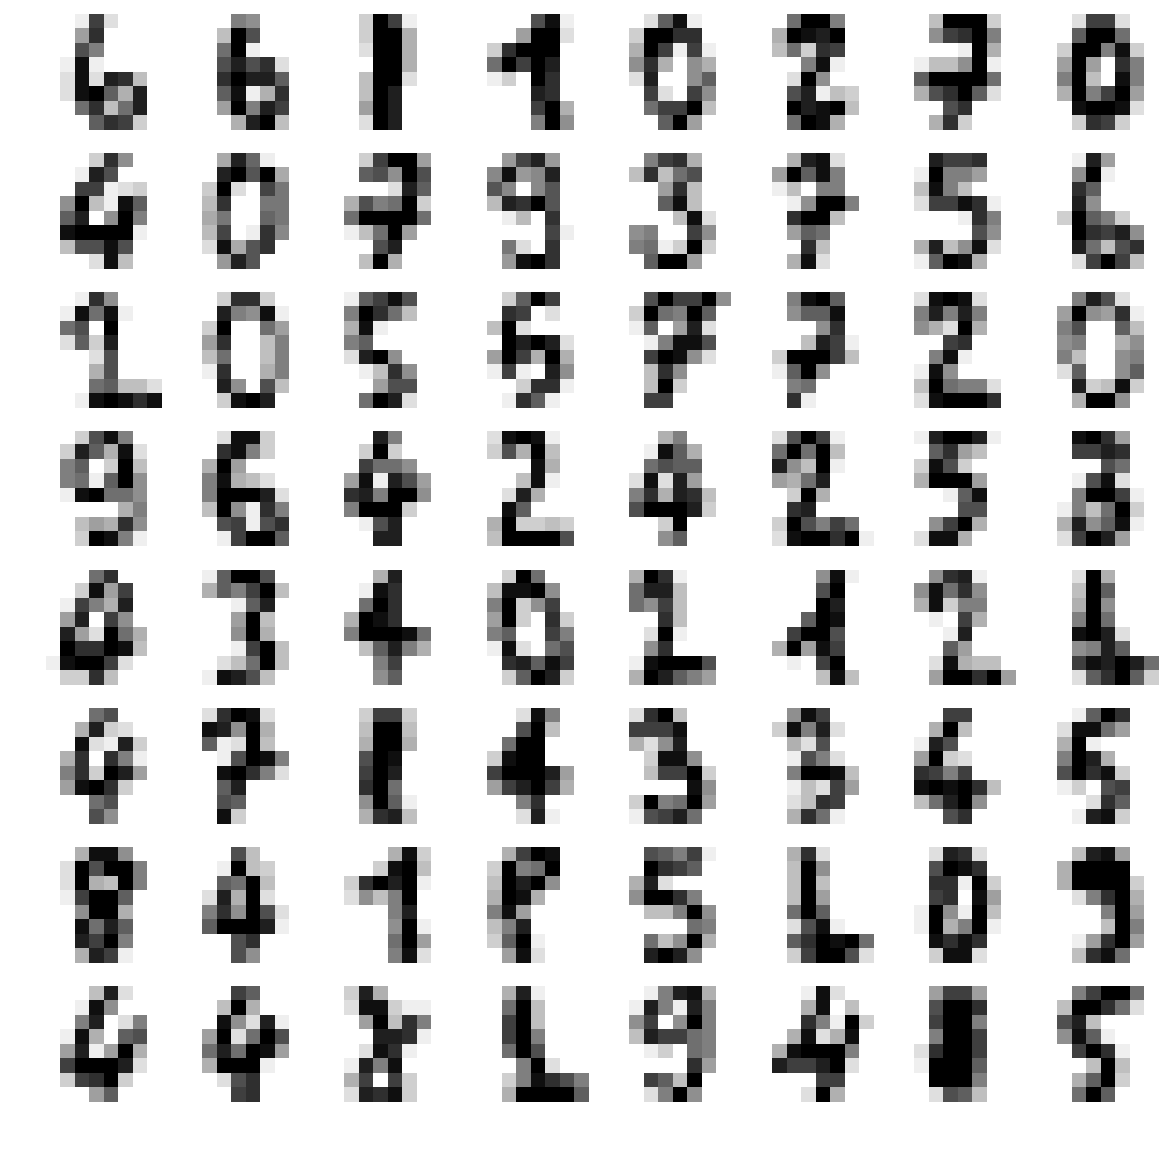

In [3]:
n_rows = 8
n_cols = 8

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 10))
k = 0
for i, j in product(range(n_rows), range(n_cols)):
    image = images_train[n_cols * i + j]
    ax[i, j].imshow(image, cmap='binary', interpolation='none')
    ax[i, j].axis('off')

plt.show()
plt.close()

Each digit is originally an 8-by-8 grid of integers between 0 and 16.

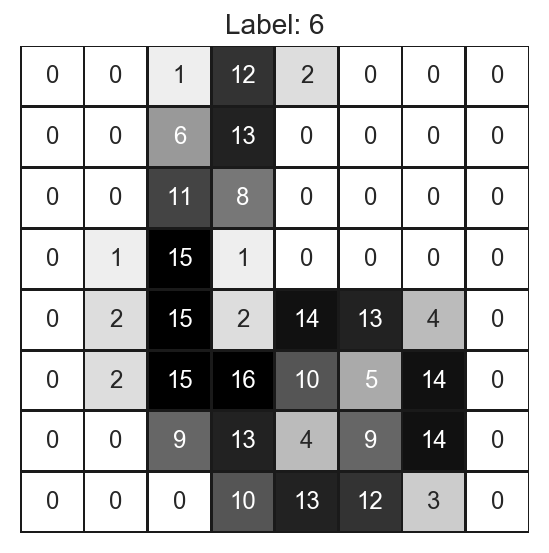

In [4]:
plt.figure(figsize=(4, 4))
index = 0
digit = (15 * images_train[index]).astype(np.int_)
sns.heatmap(digit, vmin=0, vmax=15, cmap='binary', annot=True, fmt='d',
            annot_kws={'fontsize': 12}, cbar=False, linewidths=1,
            linecolor='k')
plt.xticks([])
plt.yticks([])
plt.title('Label: %d' % y_train[index], fontsize=14)
plt.tight_layout()
plt.show()
plt.close()

It could also be useful to visualize the relationship between the features (the 8-by-8 pixel grids) and the targets (the actual digits they represent).
However, since the feature data are not two-dimensional, there is no simple way to plot the feature-target pairs.
By reducing the features to 2 dimensions using [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA), we can display a scatter plot of the "lossily compressed" features and their true target values.

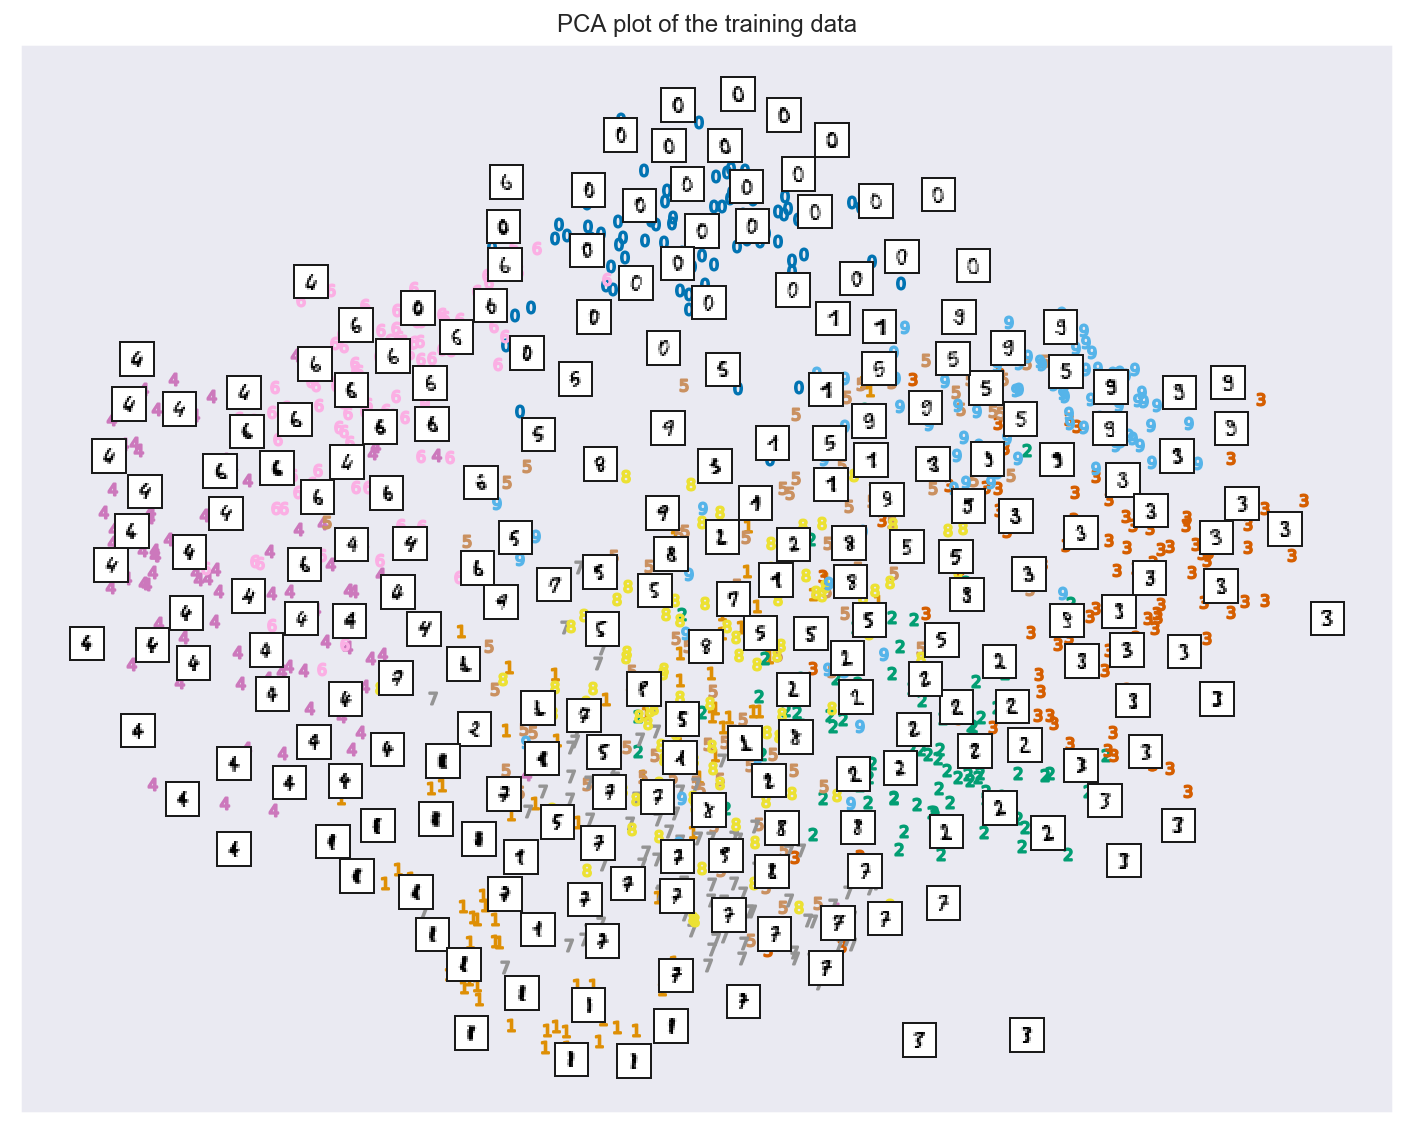

In [5]:
# Embed the training images into a 2D principal component space
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)

plt.figure(figsize=(10, 8))

# Plot each image's label on its point in principal component space
for label in range(n_classes):
    marker = '$%d$' % label
    mask = (y_train == label)
    plt.scatter(X_train_2d[mask, 0], X_train_2d[mask, 1], marker=marker)

x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
min_dist = max(x_max - x_min, y_max - y_min) / 2e2

# Plot some digits on top of the scatter plot
displayed = np.asarray([[np.inf, np.inf]])
for image, xi in zip(images_train, X_train_2d):

    # Compute the distance (in the principal component space) between the
    # current image and the images that have been displayed already. If the
    # current image is too close to one of the displayed images, then move on 
    dist = np.sum((xi - displayed) ** 2, 1)
    if np.min(dist) < min_dist:
        continue
    
    # Add the current image to the list of displayed images
    displayed = np.r_[displayed, [xi]]
    
    # Add the current image to the plot
    imagebox = offsetbox.AnnotationBbox(
        offsetbox.OffsetImage(image, cmap='binary'), xi)
    plt.gca().add_artist(imagebox)

plt.title('PCA plot of the training data')
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()
plt.close()

## Fitting the LogitBoost Model

Next, we initialize a [LogitBoost](https://logitboost.readthedocs.io/logitboost.html#logitboost.LogitBoost) classifier and fit it to the training data.
For the base estimator we'll use a decision tree regressor with depth $3$.

In [6]:
lboost = LogitBoost(DecisionTreeRegressor(max_depth=3),
                    n_estimators=30, random_state=0)
lboost.fit(X_train, y_train)

LogitBoost(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
      bootstrap=False, learning_rate=1.0, max_response=4.0,
      n_estimators=30, random_state=0, weight_trim_quantile=0.05)

## Prediction Accuracy

As a first indicator of how well the model predicts the correct labels, we can check its accuracy score (number of correct predictions over the number of total predictions) on the training and test data.
If the classifier is good, then the accuracy score should be close to 1.

In [7]:
y_pred_train = lboost.predict(X_train)
y_pred_test = lboost.predict(X_test)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

print('Training accuracy: %.4f' % accuracy_train)
print('Test accuracy:     %.4f' % accuracy_test)

Training accuracy: 1.0000
Test accuracy:     0.9783


## Precision and Recall

We can also report our LogitBoost model's [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall).

In [8]:
report_train = classification_report(y_train, y_pred_train)
report_test = classification_report(y_test, y_pred_test)
print('Training\n%s' % report_train)
print('Test\n%s' % report_test)

Training
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       119
           1       1.00      1.00      1.00       121
           2       1.00      1.00      1.00       118
           3       1.00      1.00      1.00       122
           4       1.00      1.00      1.00       121
           5       1.00      1.00      1.00       121
           6       1.00      1.00      1.00       121
           7       1.00      1.00      1.00       119
           8       1.00      1.00      1.00       116
           9       1.00      1.00      1.00       120

   micro avg       1.00      1.00      1.00      1198
   macro avg       1.00      1.00      1.00      1198
weighted avg       1.00      1.00      1.00      1198

Test
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        59
           1       0.97      0.97      0.97        61
           2       0.98      1.00      0.99        59
          

## Visualizing Accuracy During Boosting

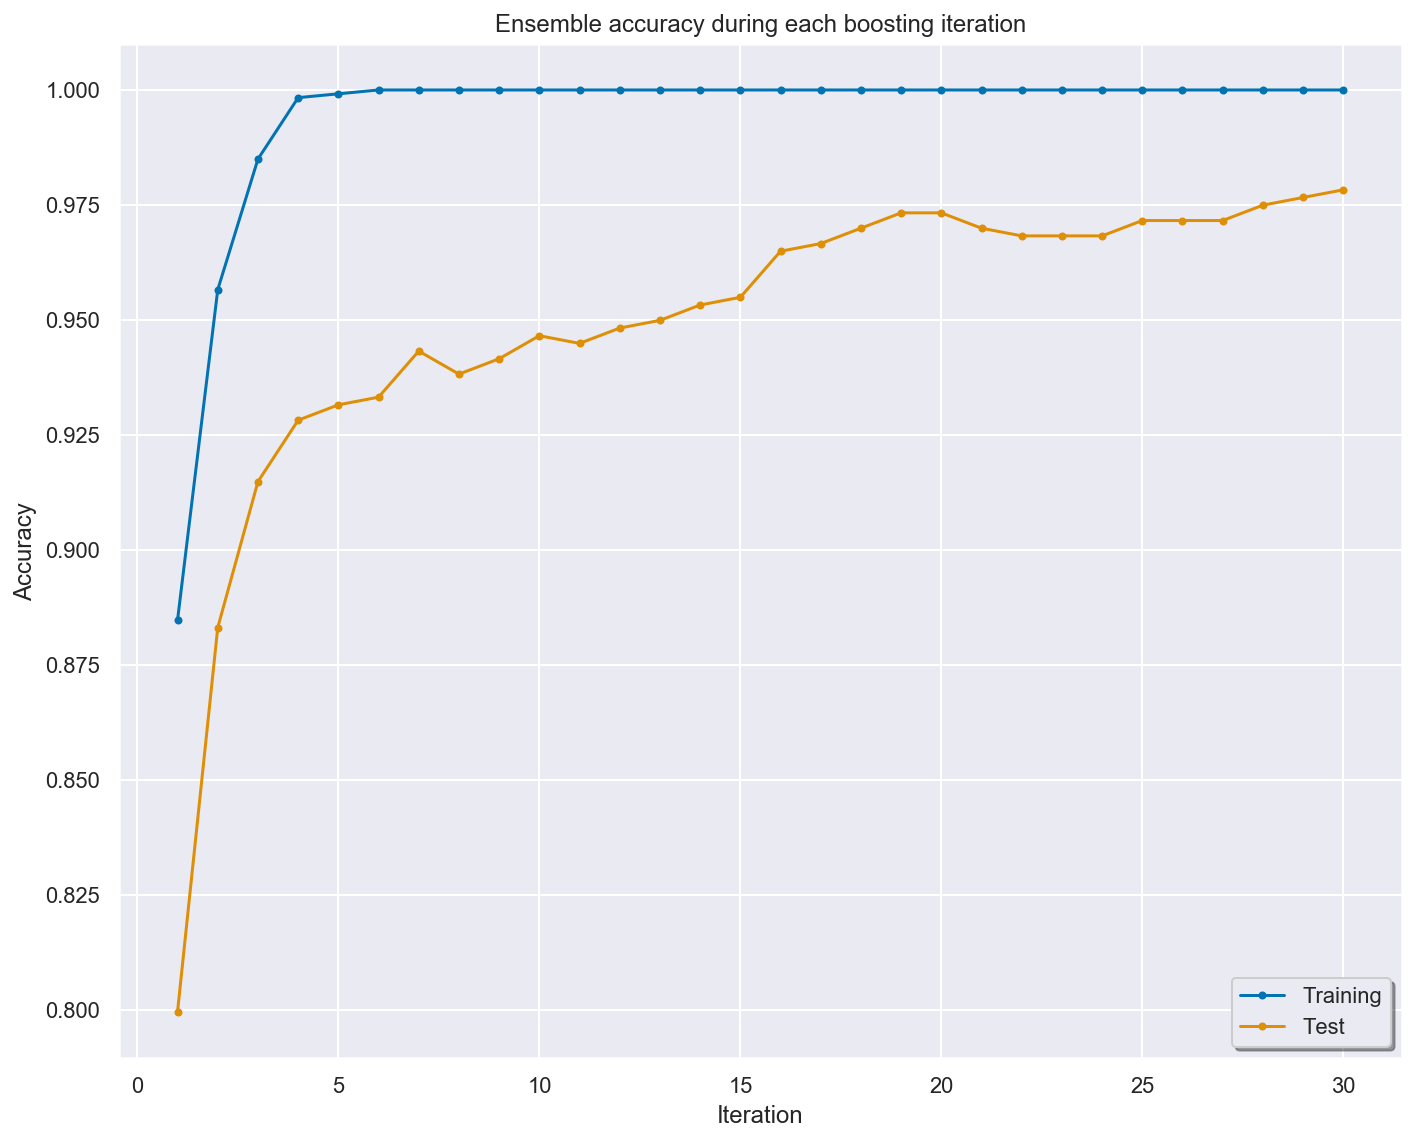

In [9]:
iterations = np.arange(1, lboost.n_estimators + 1)
staged_accuracy_train = list(lboost.staged_score(X_train, y_train))
staged_accuracy_test = list(lboost.staged_score(X_test, y_test))

plt.figure(figsize=(10, 8))
plt.plot(iterations, staged_accuracy_train, label='Training', marker='.')
plt.plot(iterations, staged_accuracy_test, label='Test', marker='.')

plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Ensemble accuracy during each boosting iteration')
plt.legend(loc='best', shadow=True, frameon=True)

plt.tight_layout()
plt.show()
plt.close()

## Exploring Misclassifications

We can use another PCA-reduced plot like the one above to visualize prediction errors made on the test data.

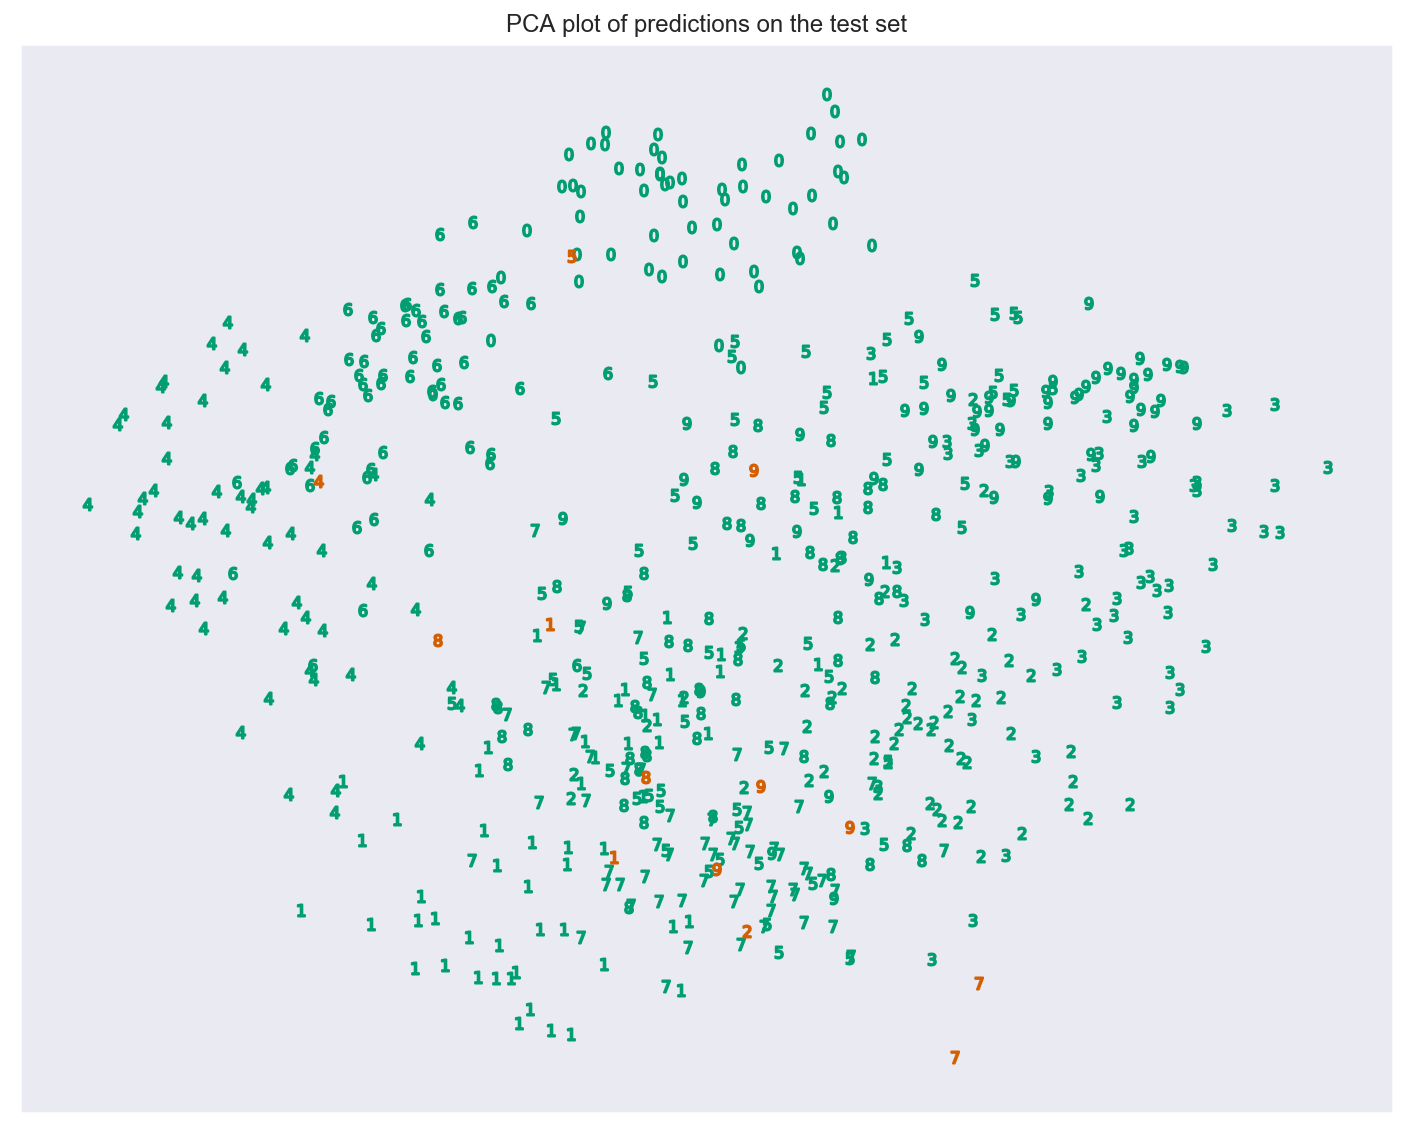

In [10]:
X_test_2d = pca.transform(X_test)

plt.figure(figsize=(10, 8))

for label_true, label_pred in product(range(n_classes), repeat=2):
    marker = '$%d$' % label_pred
    color = 'g' if label_pred == label_true else 'r'
    zorder = 1 if label_pred == label_true else 2
    mask = (y_test == label_true) & (y_pred_test == label_pred)
    plt.scatter(X_test_2d[mask, 0], X_test_2d[mask, 1],
                color=color, marker=marker, zorder=zorder)

plt.title('PCA plot of predictions on the test set')
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()
plt.close()

Each point's number is the predicted value at that point. The color signifies the prediction accuracy (green means correct, red means incorrect)

Finlly, let's see the digits in the test set that were misclassified and what the LogitBoost model believes they actually are.

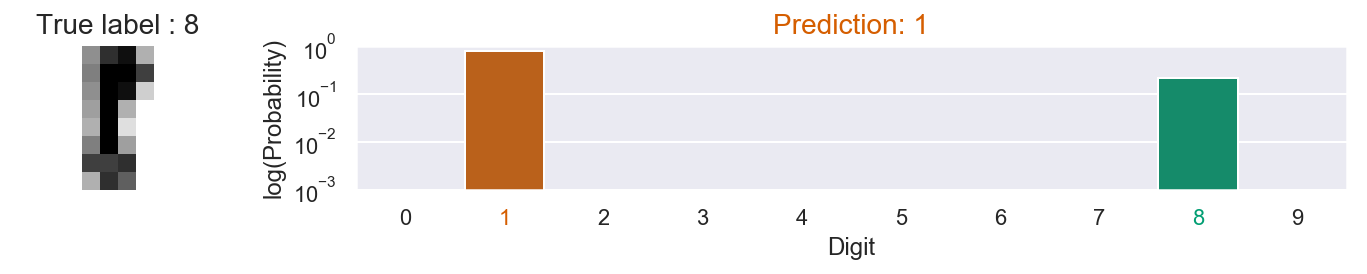

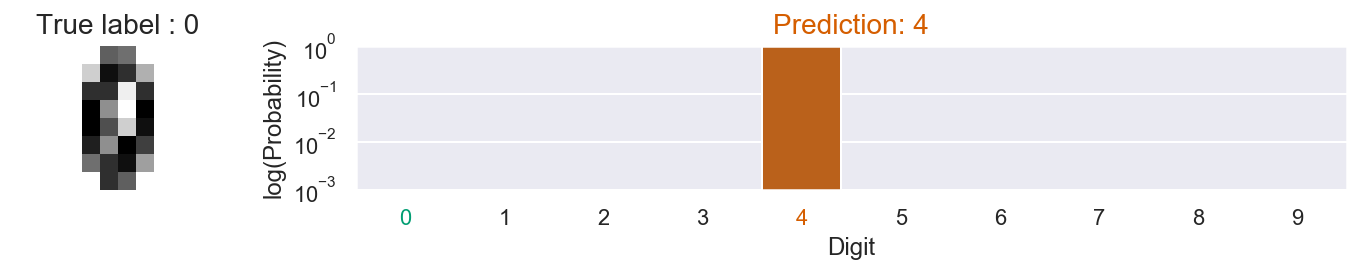

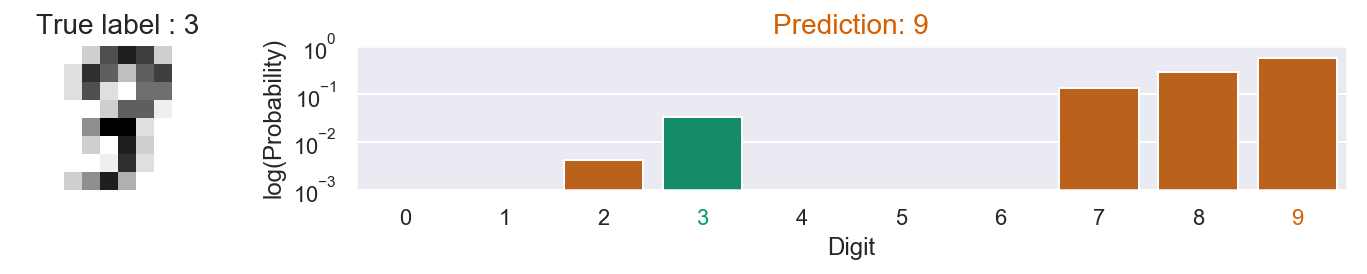

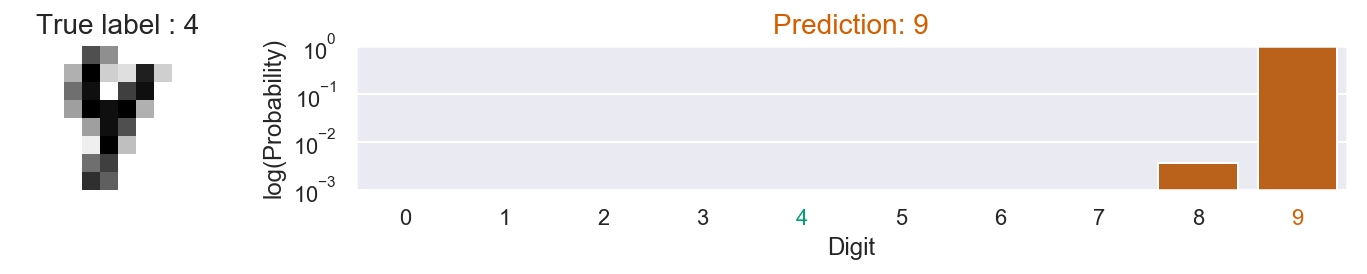

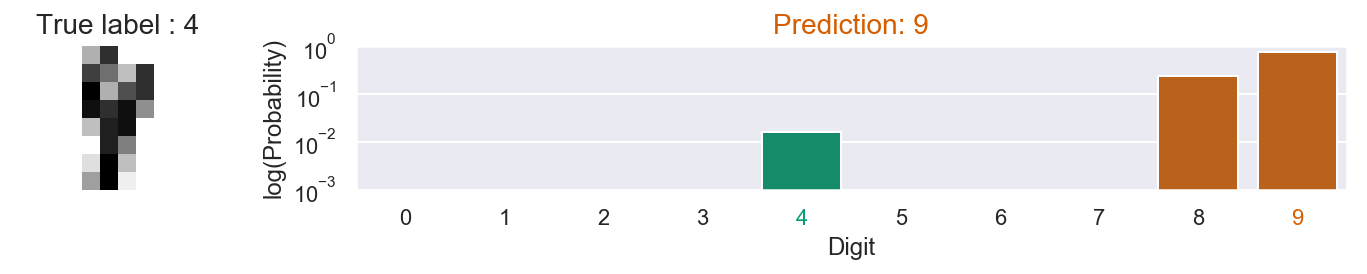

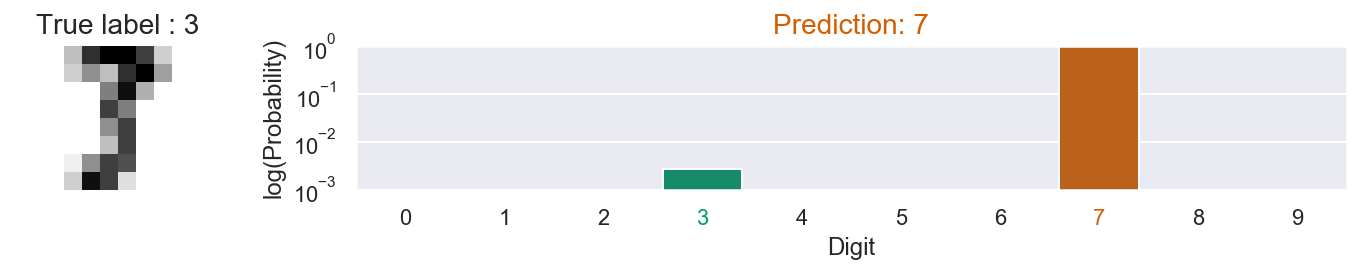

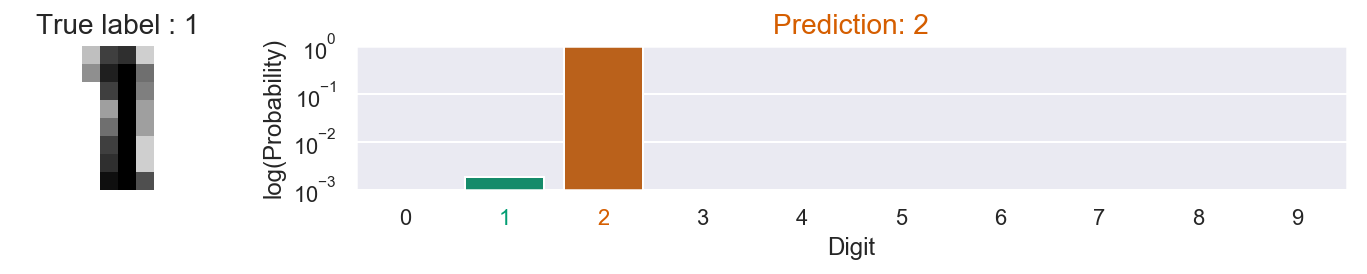

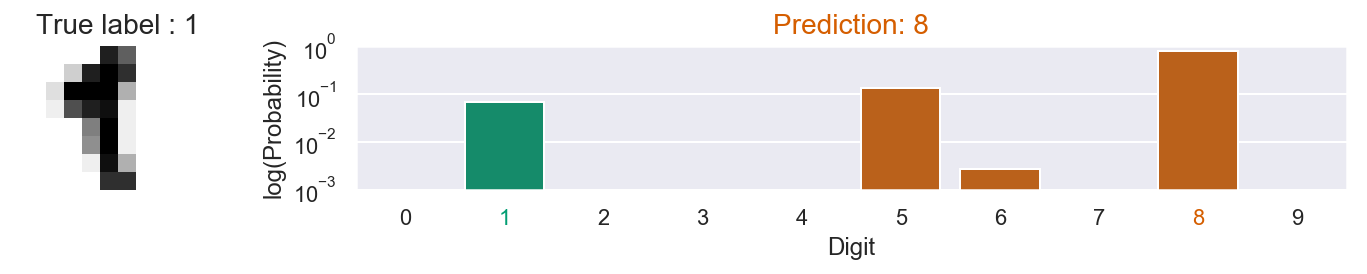

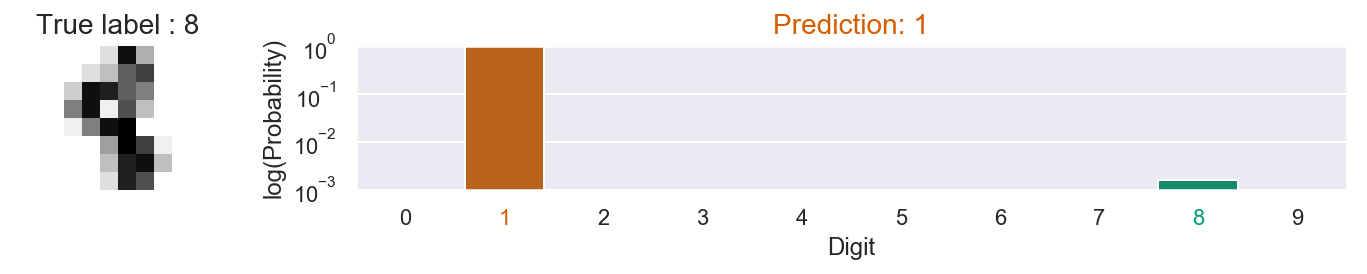

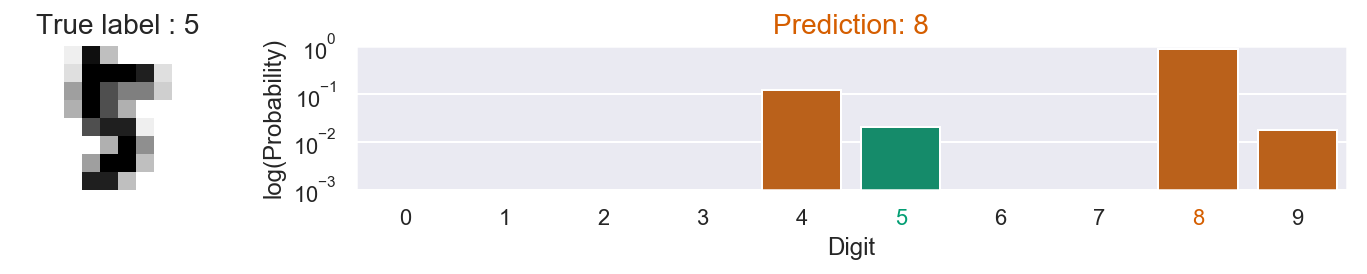

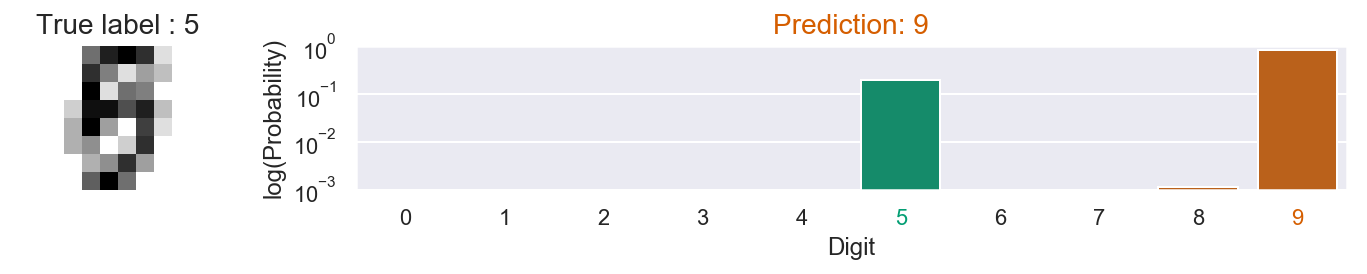

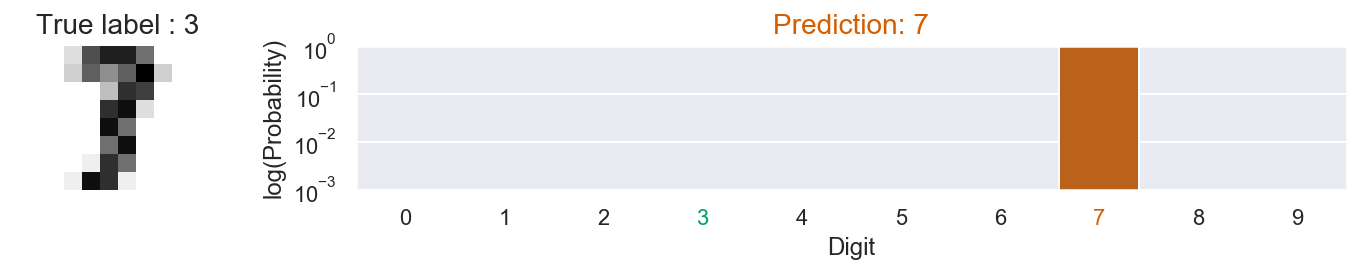

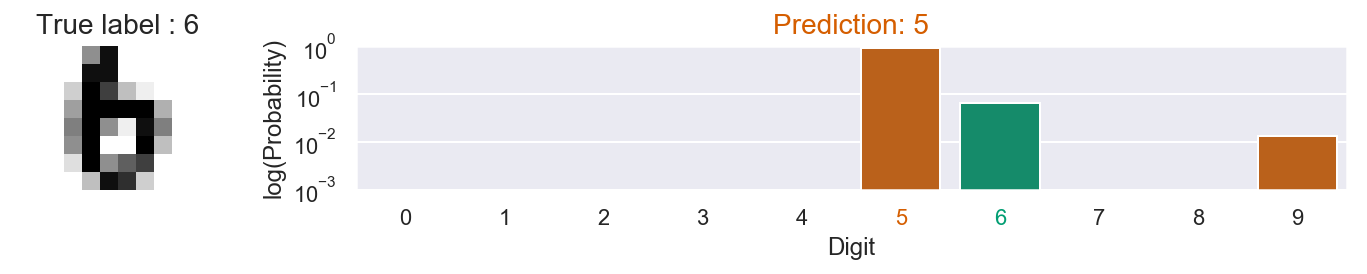

In [11]:
# Estimated class probabilities for the test set
prob_test_pred = lboost.predict_proba(X_test)

# Indices of the misclassified test examples
incorrect = (y_test != y_pred_test)
incorrect = np.where(incorrect)[0]

for i in range(len(incorrect)):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 2),
                           gridspec_kw={'width_ratios': [1, 4]})
    ax = ax.ravel()

    # Reassign i to the index of the ith incorrectly classified example
    i = incorrect[i]

    # Show the wrongly classified image
    image = X_test[i].reshape(8, 8)
    ax[0].imshow(image, cmap='binary')
    ax[0].axis('off')
    ax[0].set_aspect('equal', 'box')
    
    palette = ['r'] * n_classes
    palette[y_test[i]] = 'g'
    sns.barplot(x=np.arange(n_classes), y=prob_test_pred[i],
                ax=ax[1], palette=palette)
    ax[1].set(ylabel='log(Probability)', xlabel='Digit')
    ax[1].set(yscale='log', ylim=(1e-3, 1))
    
    true_label = y_test[i]
    pred_label = y_pred_test[i]
    color = 'r' if true_label != pred_label else 'g'
    ax[1].get_xticklabels()[true_label].set_color('g')
    ax[1].get_xticklabels()[pred_label].set_color(color)
    
    ax[0].set_title('True label : %r' % true_label, fontsize=14)
    ax[1].set_title('Prediction: %r' % pred_label, color=color, fontsize=14)
    
    plt.tight_layout()
    plt.show()
    plt.close()

## Appendix: System Information

This is included for replicability.

In [12]:
# sys_info.py is a file in the same directory as these example notebooks:
# doc/source/examples
import sys_info


Machine
      Platform: Darwin-18.2.0-x86_64-i386-64bit
  Machine Type: x86_64
     Processor: i386

Python
       Version: 3.7.2 (v3.7.2:9a3ffc0492, Dec 24 2018, 02:44:43) 
                [Clang 6.0 (clang-600.0.57)]
Implementation: CPython

Packages
         numpy: 1.16.1
         scipy: 1.2.1
    matplotlib: 3.0.2
       seaborn: 0.9.0
       sklearn: 0.20.2
